# Tutorial 5 - Mouse embryo (Spatial Mux-seq)

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [ ]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *

config = get_default_config()
setup_seed(config['training']['seed'], 'strict')


## Load data

For preprocessing epigenomics raw data to gene score, please refer to https://github.com/liranmao/Spatial_multi_omics

In [3]:
file_path = '../../../project/SpatialMultimodal/all_data/Spatial_mux_seq'

In [4]:
adata1_27me3 = sc.read_h5ad(os.path.join(file_path, 'E13_50_1_H3K27me3.h5ad'))
adata1_27ac  = sc.read_h5ad(os.path.join(file_path, 'E13_50_1_H3K27ac.h5ad'))

adata2_27me3 = sc.read_h5ad(os.path.join(file_path, 'E13_50_3_H3K27me3.h5ad'))
adata2_atac  = sc.read_h5ad(os.path.join(file_path, 'E13_50_3_ATAC.h5ad'))
adata2_rna   = sc.read_h5ad(os.path.join(file_path, 'E13_50_3_RNA.h5ad'))
adata2_4me3  = sc.read_h5ad(os.path.join(file_path, 'E13_50_3_H3K4me3.h5ad'))

adata1_27me3.obsm['spatial'] = adata1_27me3.obsm['spatial_local'].copy()
adata1_27ac.obsm['spatial'] = adata1_27ac.obsm['spatial_local'].copy()
adata2_27me3.obsm['spatial'] = adata2_27me3.obsm['spatial_local'].copy()
adata2_atac.obsm['spatial'] = adata2_atac.obsm['spatial_local'].copy()
adata2_rna.obsm['spatial'] = adata2_rna.obsm['spatial_local'].copy()
adata2_4me3.obsm['spatial'] = adata2_4me3.obsm['spatial_local'].copy()

In [5]:
adata2_rna.var_names_make_unique()

## Define the dictionary structure for input data


Each column denotes one section and None represents that the modality is missing in that section.

In [6]:
data_dict = {
        'H3K27me3': [adata1_27me3, adata2_27me3],
        'H3K27ac': [adata1_27ac, None],
        'ATAC': [None, adata2_atac],
        'RNA': [None, adata2_rna],
        'H3K4me3': [None, adata2_4me3]
    }

In [10]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, hvg_num=3000, n_comps=50, target_sum=1e5)

-------- Processing shared modality H3K27me3 across sections --------


2025-04-30 20:43:55,507 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony for H3K27me3


2025-04-30 20:43:57,923 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-30 20:43:57,977 - harmonypy - INFO - Iteration 1 of 10
2025-04-30 20:43:59,493 - harmonypy - INFO - Iteration 2 of 10
2025-04-30 20:44:00,850 - harmonypy - INFO - Iteration 3 of 10
2025-04-30 20:44:02,875 - harmonypy - INFO - Iteration 4 of 10
2025-04-30 20:44:04,156 - harmonypy - INFO - Iteration 5 of 10
2025-04-30 20:44:05,454 - harmonypy - INFO - Iteration 6 of 10
2025-04-30 20:44:06,757 - harmonypy - INFO - Converged after 6 iterations


-------- Processing unique modality H3K27ac for section 1 --------
-------- Processing unique modality ATAC for section 2 --------
-------- Processing unique modality RNA for section 2 --------
-------- Processing unique modality H3K4me3 for section 2 --------
Extracting spatial location for section 1
Extracting spatial location for section 2


## Specify the linkage indicator


COSIE requires a indicator dictionary to specify the cross-section linkage used during training. Here we utilized all the available strong and weak linkages between two sections.

In [11]:
Linkage_indicator = {
        ('s1', 's2'): [('H3K27me3', 'H3K27me3'), ('H3K27me3', 'ATAC'), ('H3K27me3', 'RNA'), ('H3K27me3', 'H3K4me3'),
                       ('H3K27ac', 'H3K27me3'), ('H3K27ac', 'ATAC'), ('H3K27ac', 'RNA'), ('H3K27ac', 'H3K4me3')]
    }

## Define COSIE Model and Perform Integration

After training, embeddings will be saved to `file_path` in `.npy` format.

In [12]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['H3K27me3', 'H3K27ac', 'ATAC', 'RNA', 'H3K4me3']
-------- Encoder description --------
Encoder [H3K27me3]: Input 50 → Hidden [256, 128]
Encoder [H3K27ac]: Input 50 → Hidden [256, 128]
Encoder [ATAC]: Input 50 → Hidden [256, 128]
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [H3K4me3]: Input 50 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [H3K27me3 → H3K27ac]: [128, 512, 512, 128]
Predictor [H3K27ac → H3K27me3]: [128, 512, 512, 128]
Predictor [H3K27me3 → ATAC]: [128, 512, 512, 128]
Predictor [ATAC → H3K27me3]: [128, 512, 512, 128]
Predictor [H3K27me3 → RNA]: [128, 512, 512, 128]
Predictor [RNA → H3K27me3]: [128, 512, 512, 128]
Predictor [H3K27me3 → H3K4me3]: [128, 512, 512, 128]
Predictor [H3K4me3 → H3K27me3]: [128, 512, 512, 128]
Predictor [ATAC → RNA]: [128, 512, 512, 128]
Predictor [RNA → ATAC]: [128, 512, 512, 128]
Predictor [ATAC → H3K4me3]: [128, 512, 512, 128]
Predictor [H3K4me3 → ATAC]: [128, 512, 512, 128]
Predictor [

In [13]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator)

-------- Running Full-graph training mode --------
Computing linkage between H3K27me3 (s1) and H3K27me3 (s2)
Computing linkage between H3K27me3 (s1) and ATAC (s2)
Selecting 3000 HVGs for H3K27me3 with 24333 genes for linkage construction
Selecting 3000 HVGs for ATAC with 24333 genes for linkage construction
Number of overlapping features: 535
Computing linkage between H3K27me3 (s1) and RNA (s2)
Selecting 3000 HVGs for H3K27me3 with 24333 genes for linkage construction
Selecting 3000 HVGs for RNA with 48440 genes for linkage construction
Number of overlapping features: 353
Computing linkage between H3K27me3 (s1) and H3K4me3 (s2)
Selecting 3000 HVGs for H3K27me3 with 24333 genes for linkage construction
Selecting 3000 HVGs for H3K4me3 with 24333 genes for linkage construction
Number of overlapping features: 533
Computing linkage between H3K27ac (s1) and H3K27me3 (s2)
Selecting 3000 HVGs for H3K27ac with 24333 genes for linkage construction
Selecting 3000 HVGs for H3K27me3 with 24333 gene

Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [02:42<00:00,  3.68it/s]

Running Evaluation...
Missing modality [ATAC] in Section [s1]
Using predictor [H3K27me3 → ATAC] to recover missing embedding...
Missing modality [RNA] in Section [s1]
Using predictor [H3K27me3 → RNA] to recover missing embedding...
Missing modality [H3K4me3] in Section [s1]
Using predictor [H3K27me3 → H3K4me3] to recover missing embedding...
Missing modality [H3K27ac] in Section [s2]
Using predictor [H3K27me3 → H3K27ac] to recover missing embedding...
All embeddings have been saved to ../../../project/SpatialMultimodal/all_data/Spatial_mux_seq


## Perform clustering and visualization

Perform joint clustering...


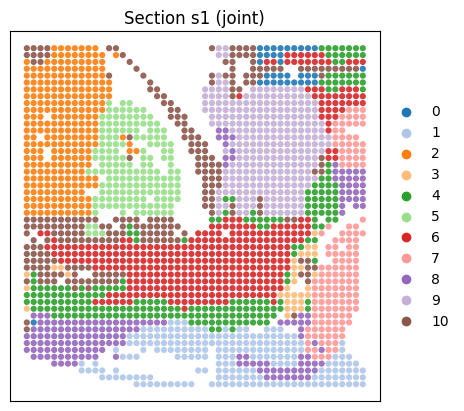

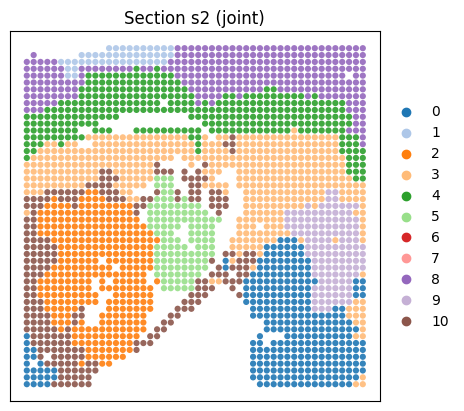

In [15]:
cluster_labels = cluster_and_visualize(final_embeddings, 
                                       data_dict,
                                       n_clusters=11,
                                       mode="joint", 
                                       vis_basis="spatial", 
                                       s=80, 
                                       plot_style='equal',
                                       dpi = 500)

## Impute ATAC for section1

In [16]:
adata1_ATAC_imputed = perform_imputation(data_dict,
    final_embeddings,
    target_section = 's1',
    target_modality = 'ATAC',
    K_num=50,
    )

Using modality [H3K27me3] in section [s1] as spatial/obs reference
[ATAC] exists in ['s2'], which will be used as source data section


In [17]:
adata1_ATAC_imputed_norm = create_normalized_adata(adata1_ATAC_imputed)
adata2_ATAC_norm = create_normalized_adata(adata2_atac)

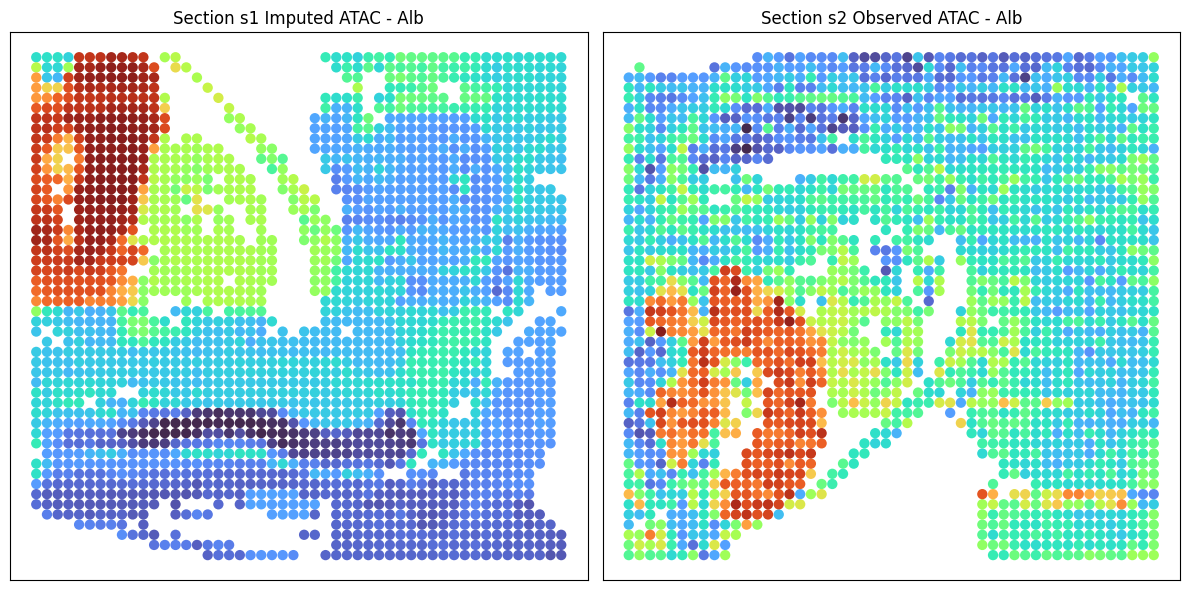

In [19]:
chosed_gene = 'Alb'
plot_marker_comparison(chosed_gene, 
                       adata1_ATAC_imputed_norm, 
                       adata2_ATAC_norm, 
                       section1_label = 'Section s1 Imputed ATAC', 
                       section2_label = 'Section s2 Observed ATAC', 
                       dpi = 200,
                       s=220)

## Impute H3K4me3 for section1

In [20]:
adata1_H3K4me3_imputed = perform_imputation(data_dict,
    final_embeddings,
    target_section = 's1',
    target_modality = 'H3K4me3',
    K_num=50,
    )

Using modality [H3K27me3] in section [s1] as spatial/obs reference
[H3K4me3] exists in ['s2'], which will be used as source data section


In [21]:
adata1_H3K4me3_imputed_norm = create_normalized_adata(adata1_H3K4me3_imputed)
adata2_H3K4me3_norm = create_normalized_adata(adata2_4me3)

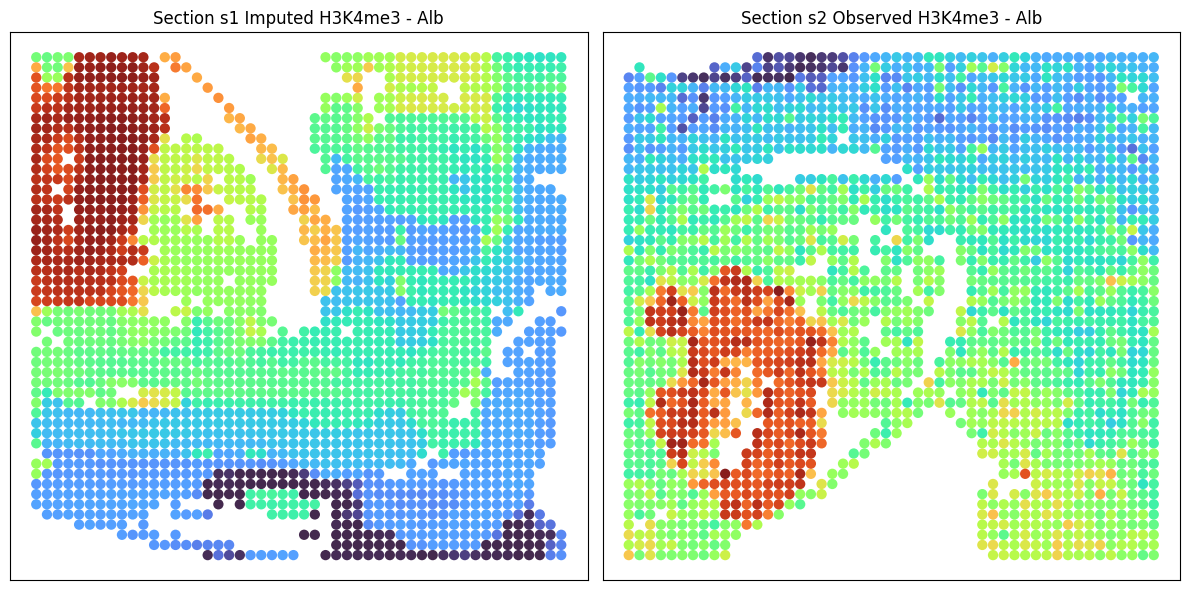

In [22]:
plot_marker_comparison(chosed_gene, 
                       adata1_H3K4me3_imputed_norm, 
                       adata2_H3K4me3_norm, 
                       section1_label = 'Section s1 Imputed H3K4me3', 
                       section2_label = 'Section s2 Observed H3K4me3', 
                       dpi = 200,
                       s=220)

## Impute RNA for section1

In [23]:
adata1_RNA_imputed = perform_imputation(data_dict,
    final_embeddings,
    target_section = 's1',
    target_modality = 'RNA',
    K_num=50,
    )

Using modality [H3K27me3] in section [s1] as spatial/obs reference
[RNA] exists in ['s2'], which will be used as source data section


In [24]:
adata1_RNA_imputed_norm = create_normalized_adata(adata1_RNA_imputed)
adata2_rna_norm = create_normalized_adata(adata2_rna)

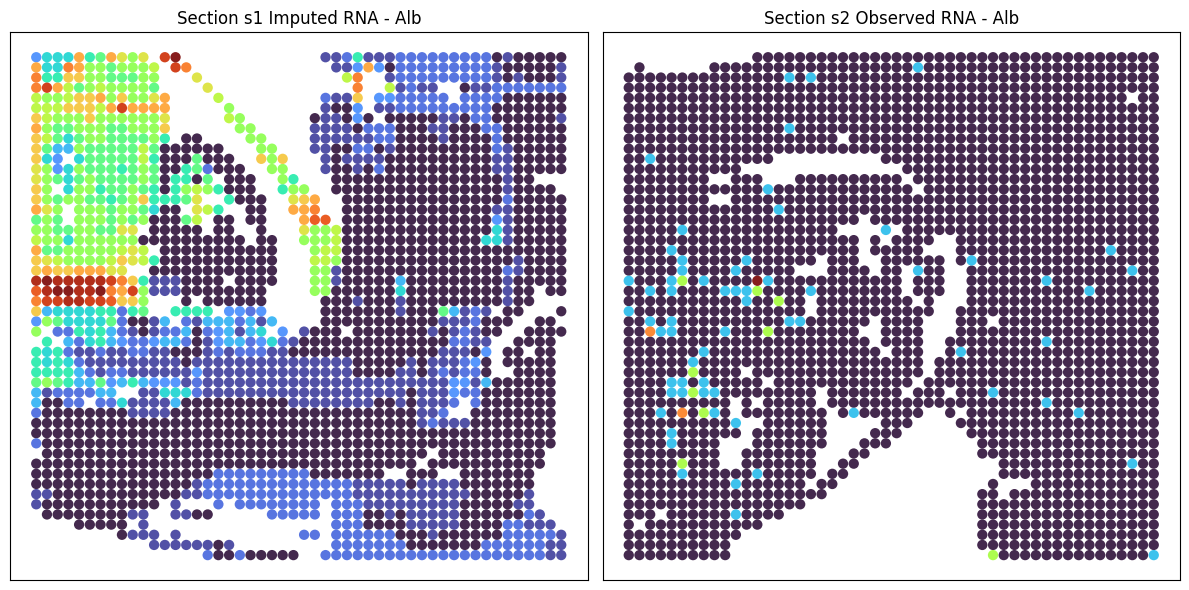

In [25]:
plot_marker_comparison(chosed_gene, 
                       adata1_RNA_imputed_norm, 
                       adata2_rna_norm, 
                       section1_label = 'Section s1 Imputed RNA', 
                       section2_label = 'Section s2 Observed RNA', 
                       dpi = 300,
                       s=220)

## Impute H3K27ac for section2

In [26]:
adata2_H3K27ac_imputed = perform_imputation(data_dict,
    final_embeddings,
    target_section = 's2',
    target_modality = 'H3K27ac',
    K_num=50,
    )

Using modality [H3K27me3] in section [s2] as spatial/obs reference
[H3K27ac] exists in ['s1'], which will be used as source data section


In [27]:
adata2_H3K27ac_imputed_norm = create_normalized_adata(adata2_H3K27ac_imputed)
adata1_27ac_norm = create_normalized_adata(adata1_27ac)

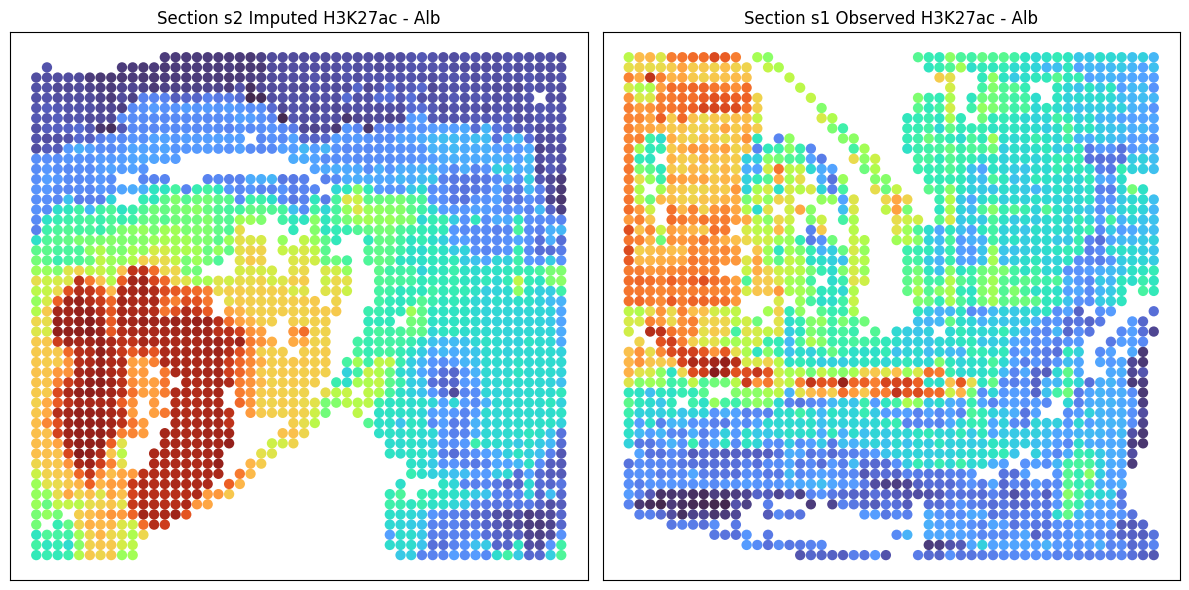

In [28]:
plot_marker_comparison(chosed_gene, 
                       adata2_H3K27ac_imputed_norm, 
                       adata1_27ac_norm, 
                       section1_label = 'Section s2 Imputed H3K27ac', 
                       section2_label = 'Section s1 Observed H3K27ac', 
                       dpi = 300,
                       s=220)